In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import dct,idct
from scipy.sparse import identity
from scipy.linalg import hadamard,svd,orth

import cvxpy as cp
import h5py

DATASET_FILE_PATH = 'generated_datasets/DSM2/datasets.h5'
STATION_NAMES = ['RSAC064', 'RSAC075', 'RSAC081', 'RSAC092', 'RSAN007','RSAN018']



In [105]:
# size of basis matrix for CS
N = 72

# generate the basis
P = idct(identity(N).toarray(), axis=0, norm='ortho')
#P = hadamard(N)

# calculate basis from training data
# with h5py.File(DATASET_FILE_PATH, "r") as hf1:
#     h5_X = hf1["train"]["X"][:]
# P = np.zeros((h5_X.shape[1],h5_X.shape[1]))
# for i in range(h5_X.shape[0]):
#     U ,s, Vh = svd(h5_X[i])
#     P += U
# P = orth(P)

def impute_cs(miss_idx, y):
    # generate observation matrices
    A = np.copy(P)
    A[miss_idx] = 0

    # recover coeffs from observations with CS
    xr = cp.Variable(N)
    eps = 0.001
    obj = cp.Minimize(cp.norm(xr,1))
    constr = [cp.norm(A@xr-y,2) <= eps]
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.CVXOPT, verbose=False)

    # calculate recovered signal
    sr = np.matmul(P,xr.value)

    return sr

## Generate synthetic test data

In [ ]:
# parameters
N = 512
T = 3
K = 32

# generate test signal
s_i = np.cos(2*np.pi*1*np.linspace(0,1,int(N/32))) + np.random.normal(0,0.1,int(N/32))
S = np.zeros((int(N/32),32))
for i in range(32):
    S[:,i] = s_i
s = np.zeros(N)
for i in range(32):
    for j in range(int(N/32)):
        s[int(N/32)*i+j] = S[j,i]

# random sampling of the signal
smpl_idx = np.sort(np.random.permutation(N)[:K])
y = np.zeros(s.shape)
y[smpl_idx] = s[smpl_idx]

In [ ]:
plt.figure()
plt.plot(s_i)

plt.figure()
plt.plot(S[:,1])

plt.figure()
plt.imshow(S)

## Test DSM2 data

In [106]:
# read in DSM2 test data
with h5py.File(DATASET_FILE_PATH, "r") as hf1:
    h5_X = hf1["test"]["X"][:]
    h5_X_hat = hf1["test"]["X_hat"][:]
    h5_missing_mask = hf1["test"]["missing_mask"][:]
    h5_indicating_mask = hf1["test"]["indicating_mask"][:]

# fill in missing measurements
num_smpls,num_meas,num_stations = h5_X.shape
Y = np.zeros((num_smpls,num_meas,num_stations))
for sample in range(num_smpls):
    for station in range(num_stations):
        if np.equal(h5_missing_mask[sample,:,station],0).any():
            s_hat = np.zeros(N)
            s_hat[:num_meas] = h5_X_hat[sample,:,station]
            miss_idx = np.where(h5_missing_mask[sample,:,station]==0)[0]
            s_hat[miss_idx] = 0
            sr = impute_cs(miss_idx, s_hat)
            Y[sample,:,station] = h5_X_hat[sample,:,station]
            Y[sample,miss_idx,station] = sr[miss_idx]
        else:
            Y[sample,:,station] = h5_X_hat[sample,:,station]

In [107]:
import torch
from modeling.utils import masked_mae_cal, masked_mre_cal, masked_rmse_cal

data = (
    torch.tensor(0),
    torch.from_numpy(np.nan_to_num(h5_X_hat).astype("float32")),
    torch.from_numpy(h5_missing_mask.astype("float32")),
    torch.from_numpy(np.nan_to_num(h5_X).astype("float32")),
    torch.from_numpy(h5_indicating_mask.astype("float32"))
)

indices, X, missing_mask, X_holdout, indicating_mask = map(lambda x: x.to('cuda'), data)
inputs = {
    "indices": indices,
    "X": X,
    "missing_mask": missing_mask,
    "X_holdout": X_holdout,
    "indicating_mask": indicating_mask,
}


masked_mae = masked_mae_cal(torch.from_numpy(Y).to('cuda'), X_holdout, indicating_mask)
masked_mrse = masked_rmse_cal(torch.from_numpy(Y).to('cuda'), X_holdout, indicating_mask)
masked_mre = masked_mre_cal(torch.from_numpy(Y).to('cuda'), X_holdout, indicating_mask)

print('masked_mae_cal : ', masked_mae.item())
print('masked_mrse    : ', masked_mrse.item())
print('masked_mre_cal : ', masked_mre.item())

masked_mae_cal :  0.06890106404302343
masked_mrse    :  0.13473501615889436
masked_mre_cal :  0.09800654489444523


Number of missing points: 18
RSAC064 MAE: 0.1466511962807533
Number of missing points: 20
RSAC075 MAE: 0.09829266052397079
Number of missing points: 14
RSAC081 MAE: 0.19624627029719535
Number of missing points: 15
RSAC092 MAE: 0.14919139008620086
Number of missing points: 22
RSAN007 MAE: 0.0847983728127588
Number of missing points: 13
RSAN018 MAE: 0.035441105199592246


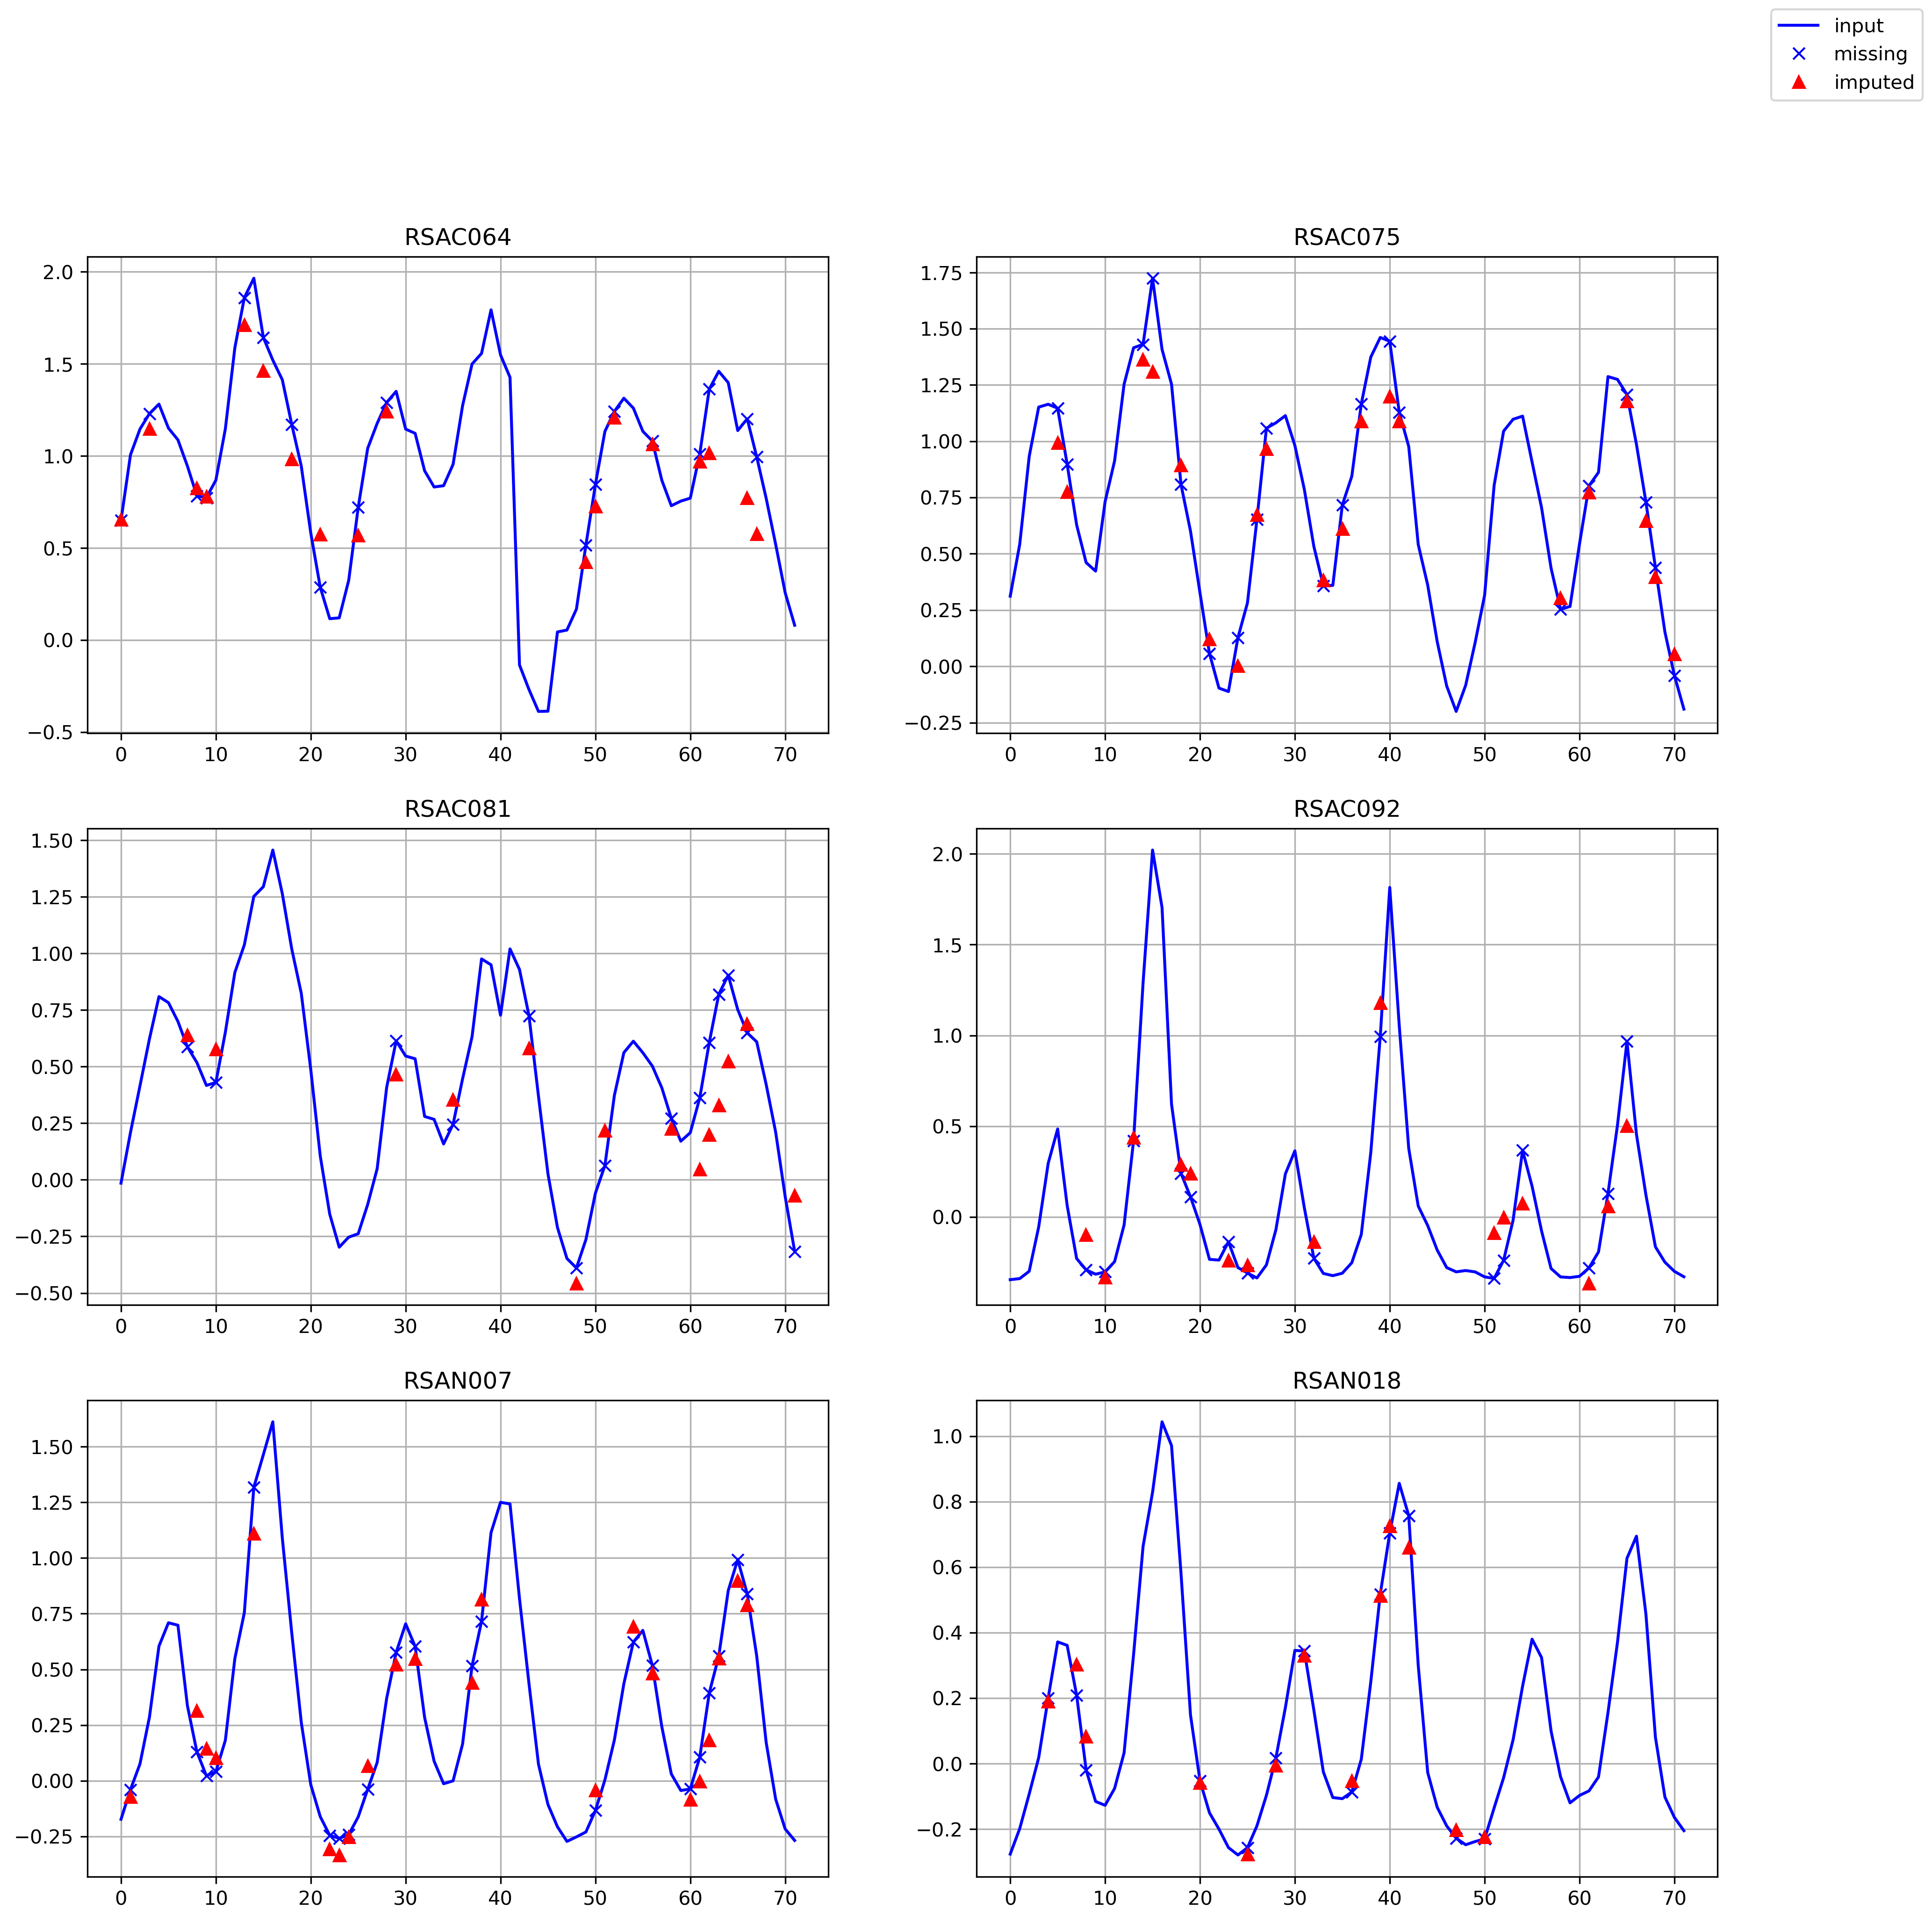

In [108]:
sample = 24

fig = plt.figure(figsize=(15,15))
for station in range(num_stations):
    s = h5_X[sample,:,station]
    sr = Y[sample,:,station]
    miss_idx = np.where(h5_missing_mask[sample,:,station]==0)[0]

    if miss_idx.any():
        e = s - sr
        mae = np.sum(abs(e[miss_idx]))/len(miss_idx)
        print('Number of missing points:', len(miss_idx))
        print(f'{STATION_NAMES[station]} MAE:', mae)

    plt.subplot(3, 2, station+1)
    plt.plot(s, '-b', label='input')
    plt.plot(miss_idx,s[miss_idx], 'xb', label='missing')
    plt.plot(miss_idx,sr[miss_idx], '^r', label='imputed')
    plt.grid(True)
    plt.title(STATION_NAMES[station])

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

## Test Hadamard Matrix

14.456248345331613


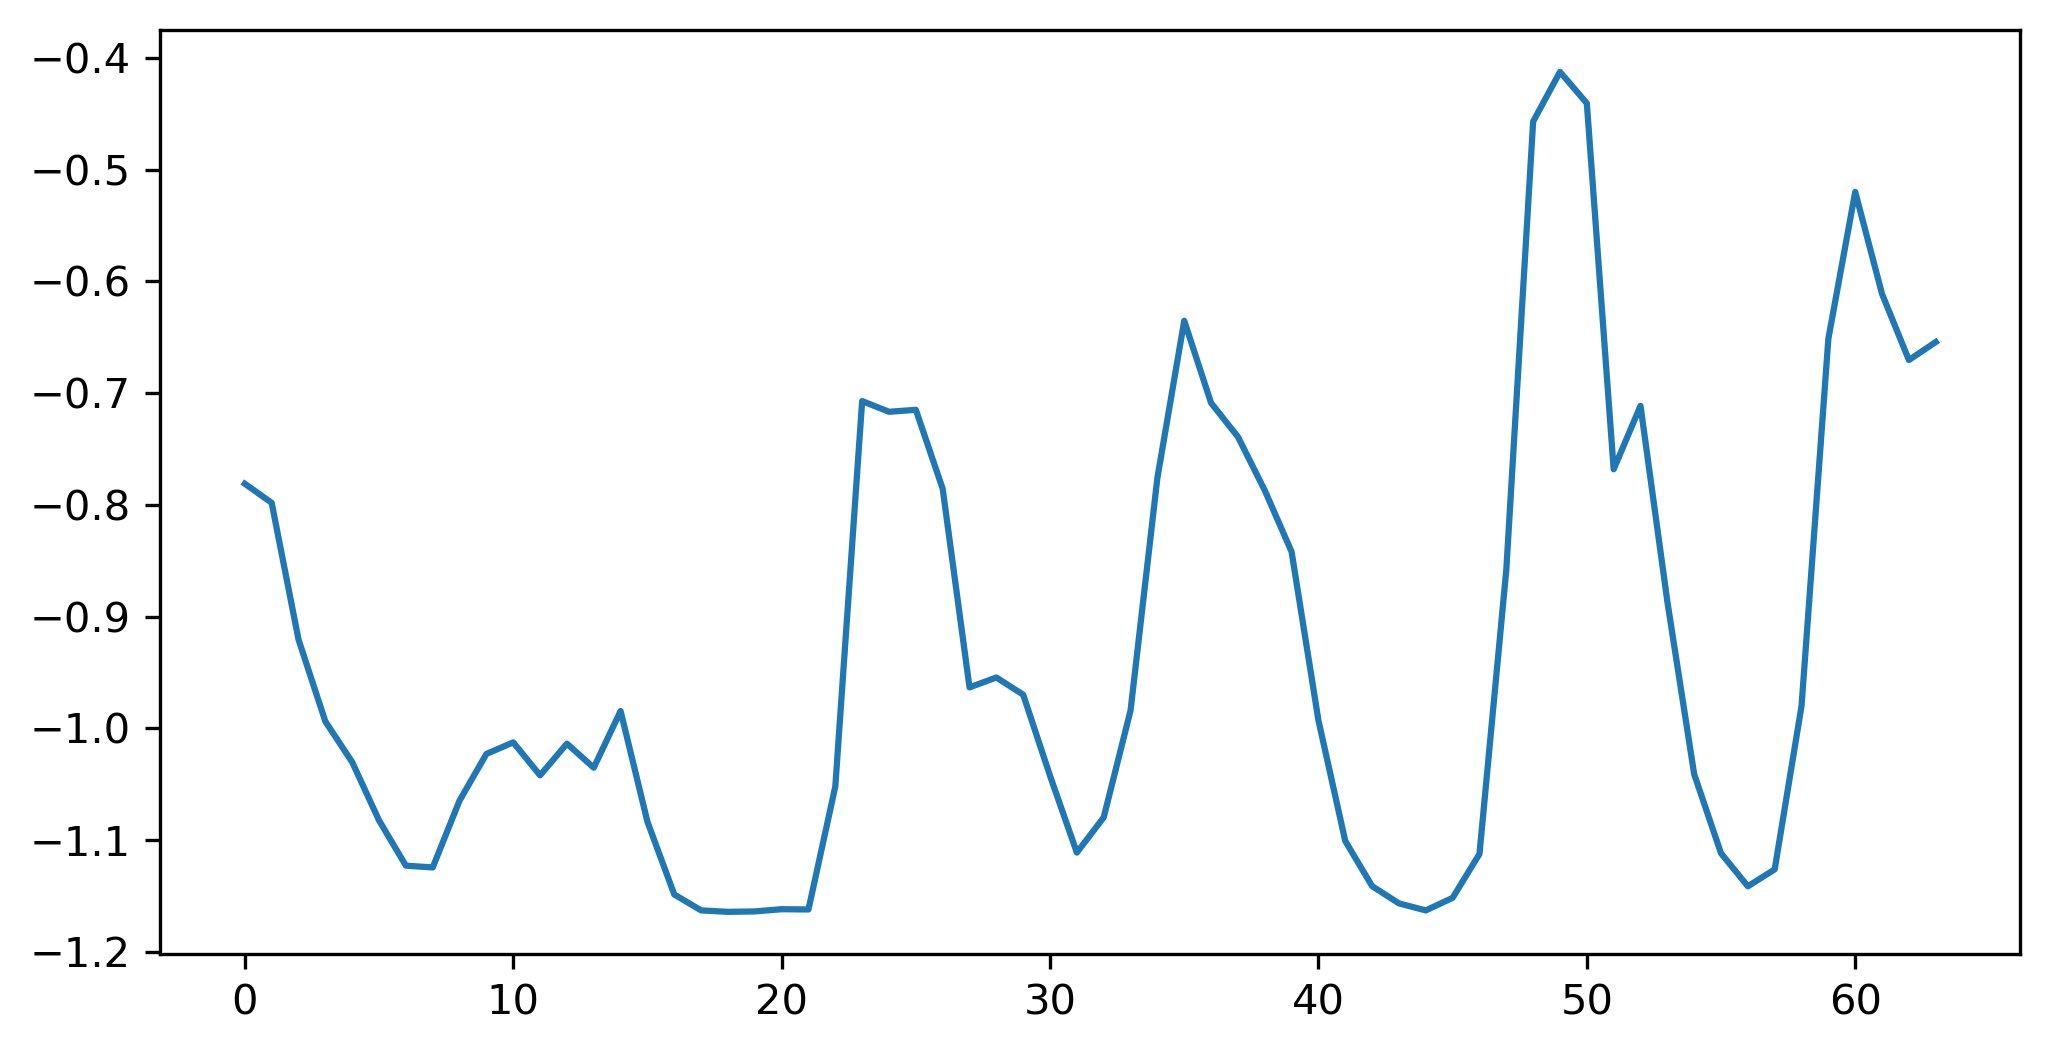

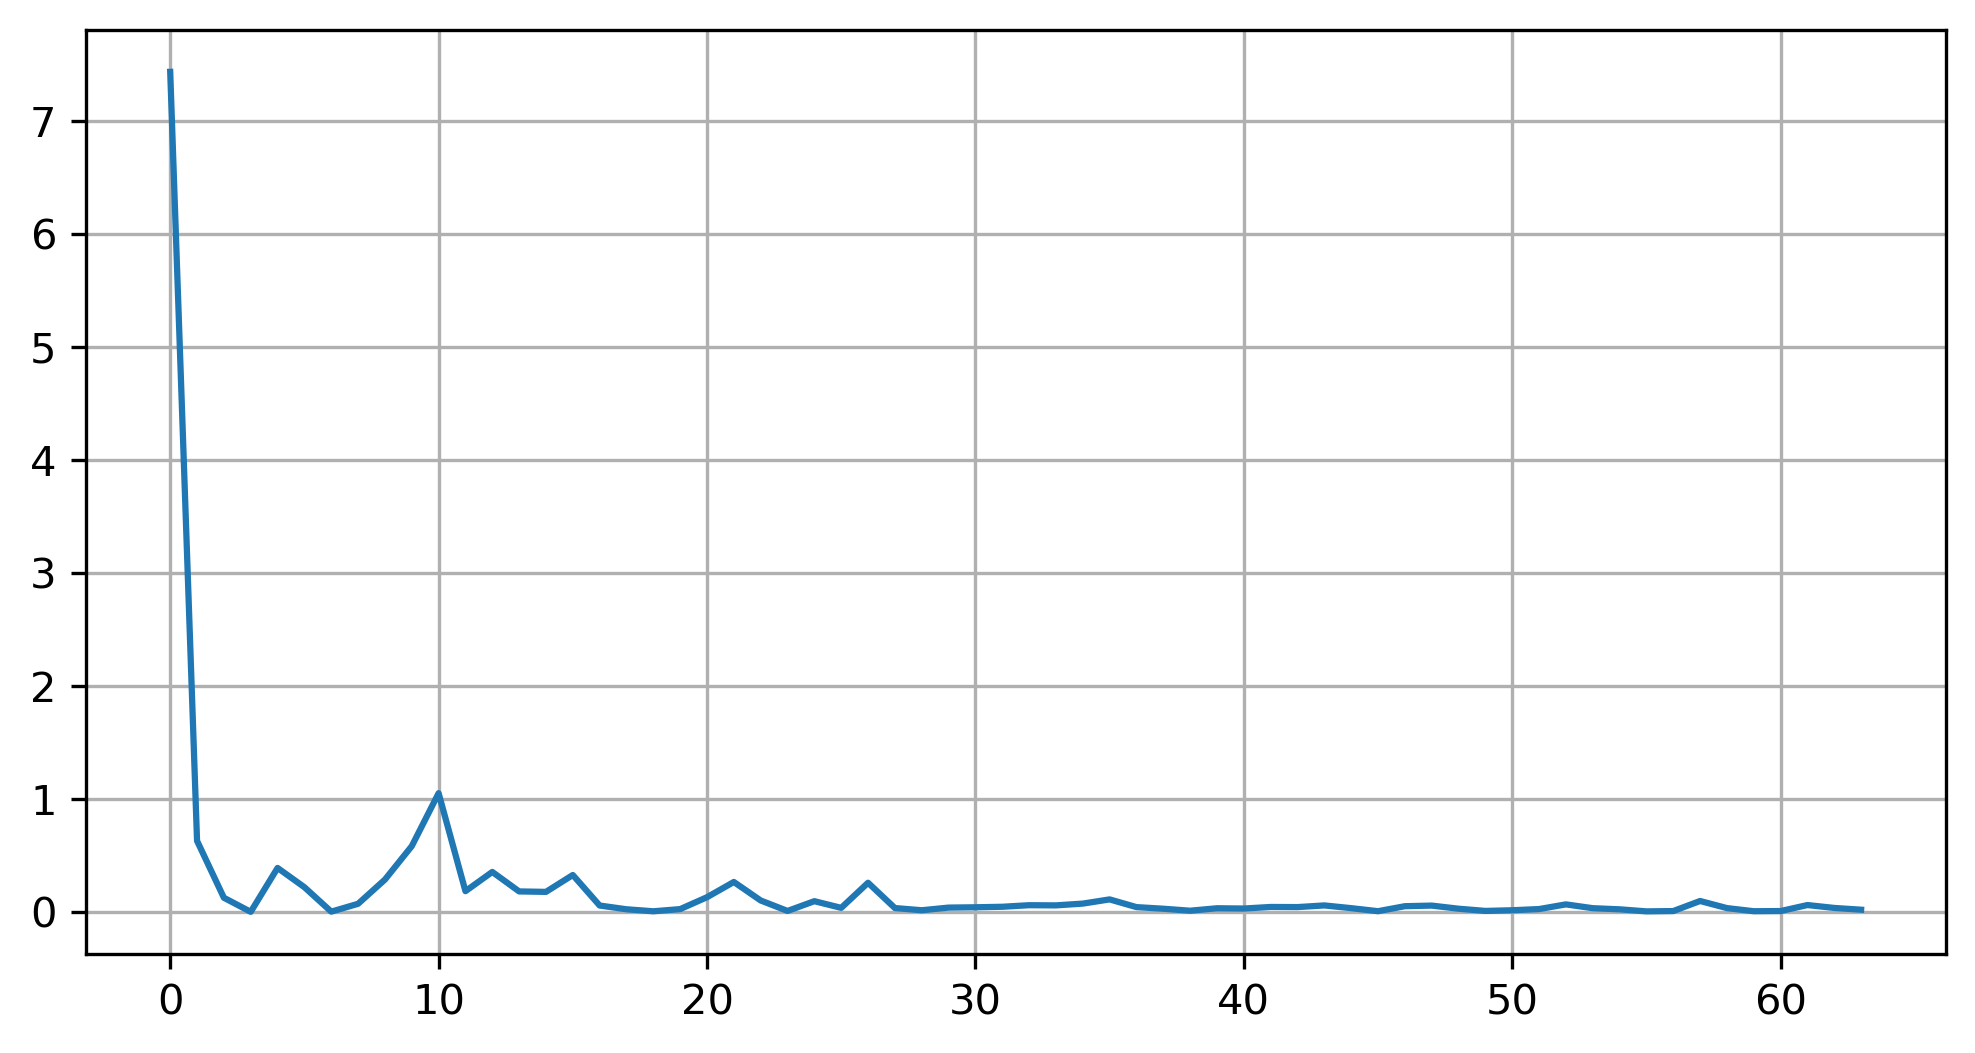

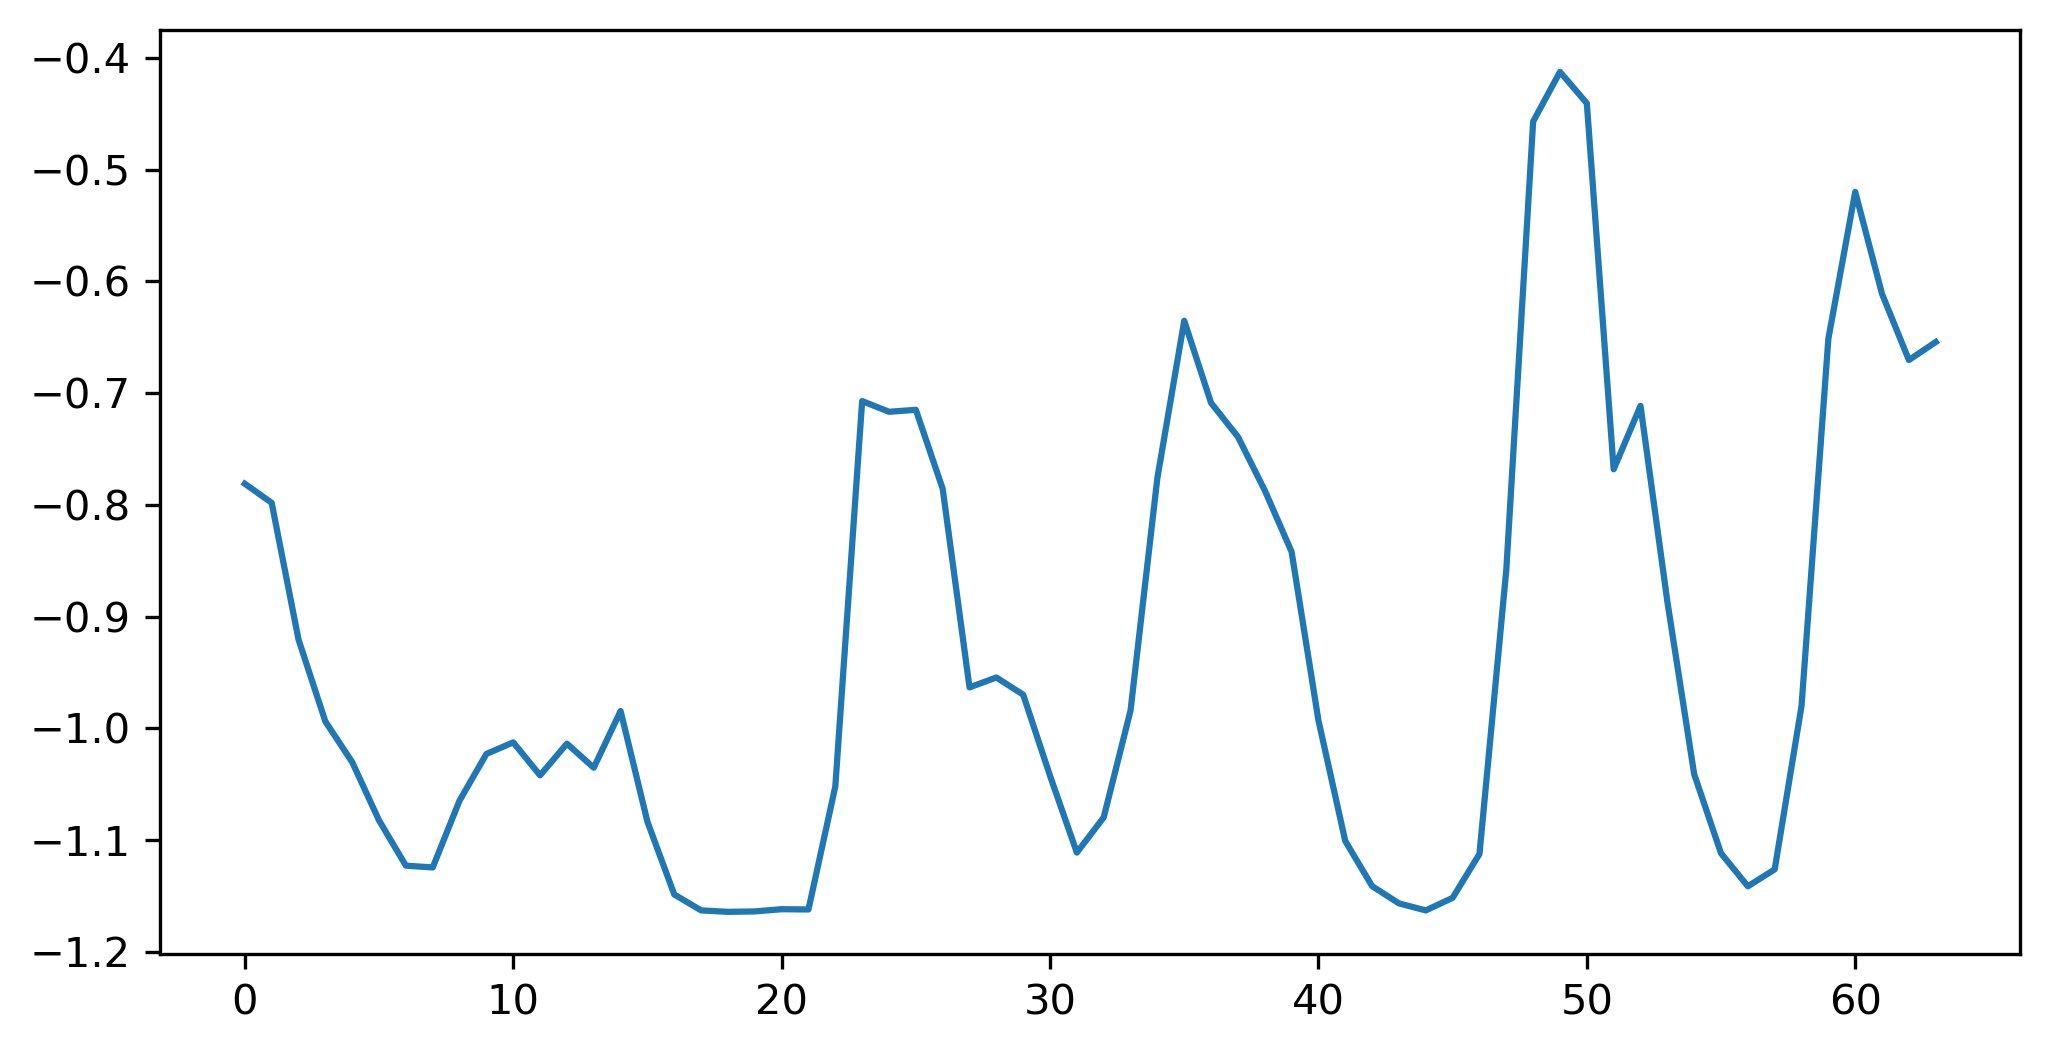

In [73]:
# test hardmard matrix
x = np.zeros(N)
x[:num_meas] = h5_X[0,:,0]

P = idct(identity(N).toarray(), axis=0, norm='ortho')
#P = hadamard(N)

plt.figure()
plt.plot(x)

X = np.matmul(x,P)

plt.figure()
plt.plot(abs(X))
plt.grid(True)
print(sum(abs(X)))

y = np.matmul(P,X)

plt.figure()
plt.plot(y)


## Test KL Transform with SVD

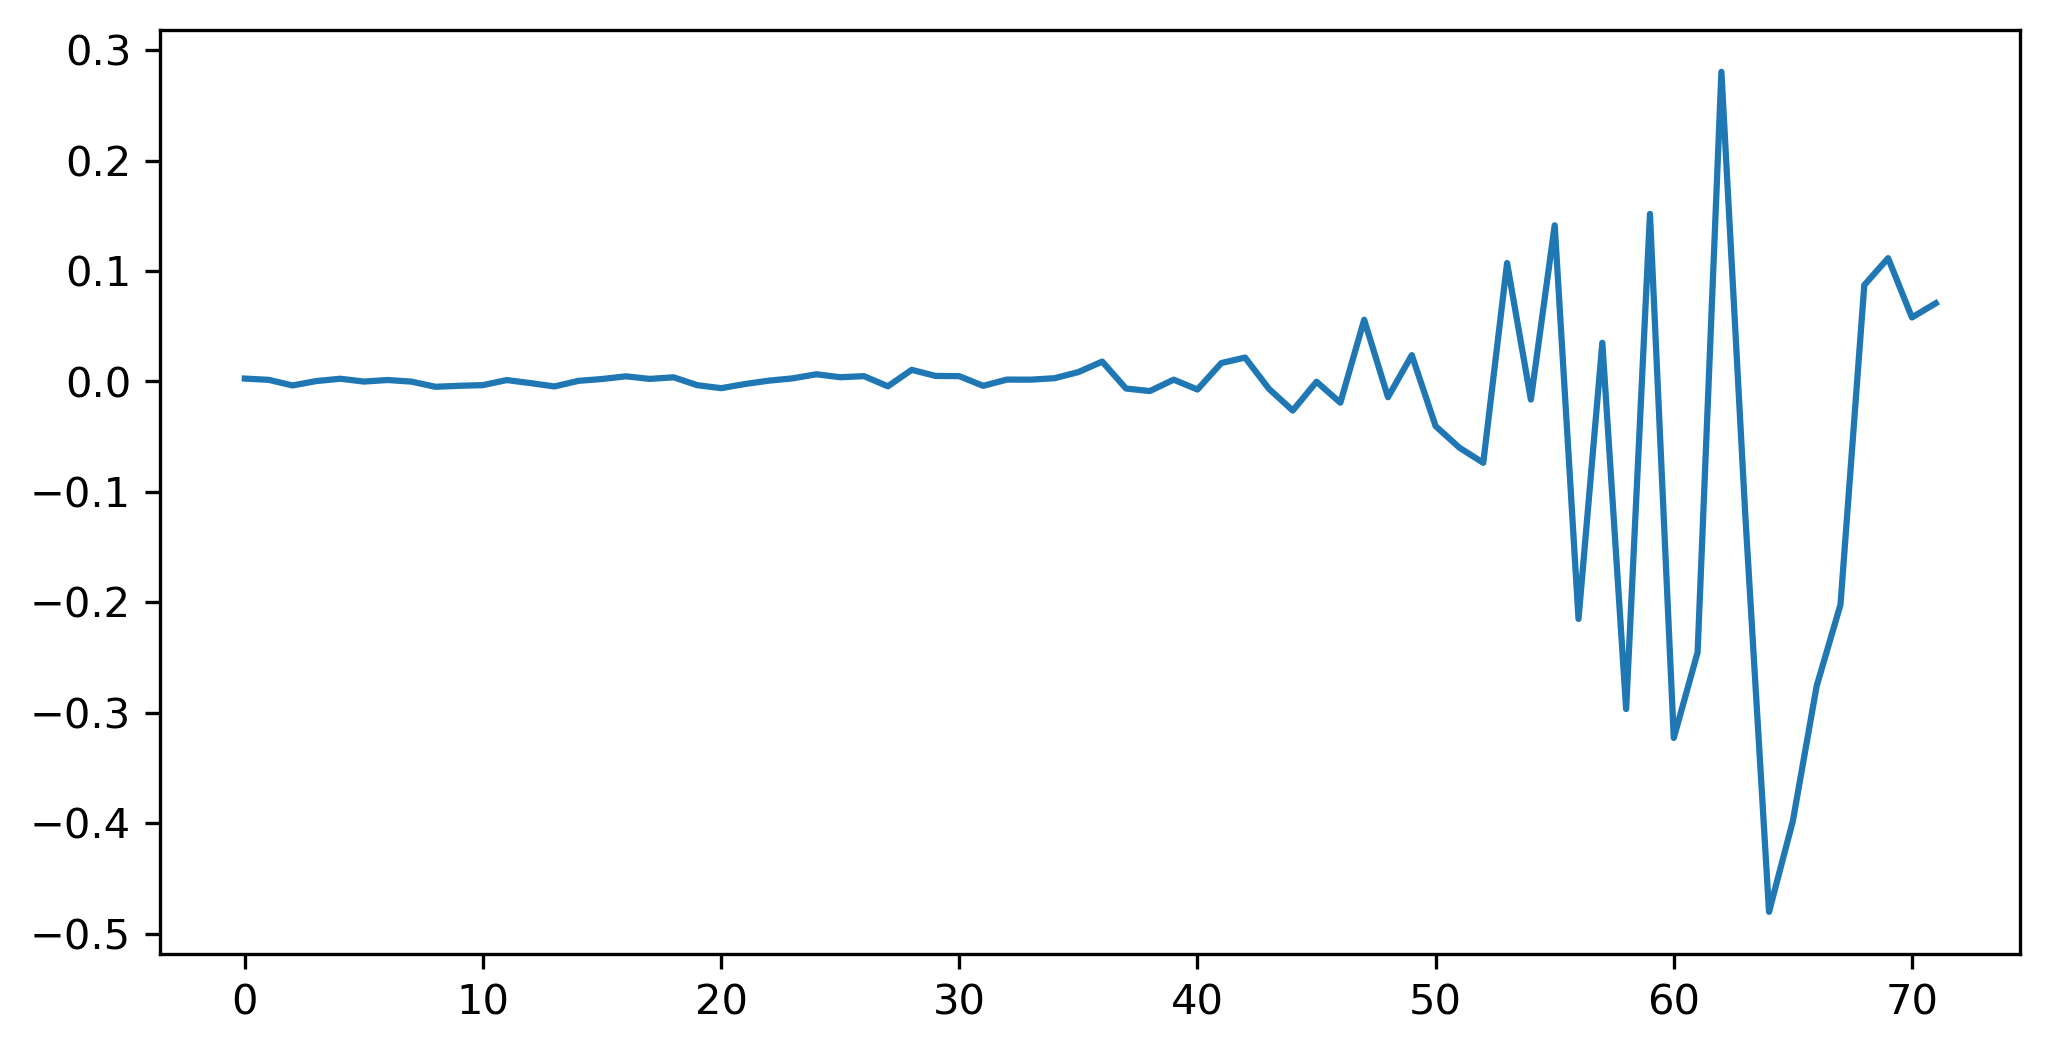

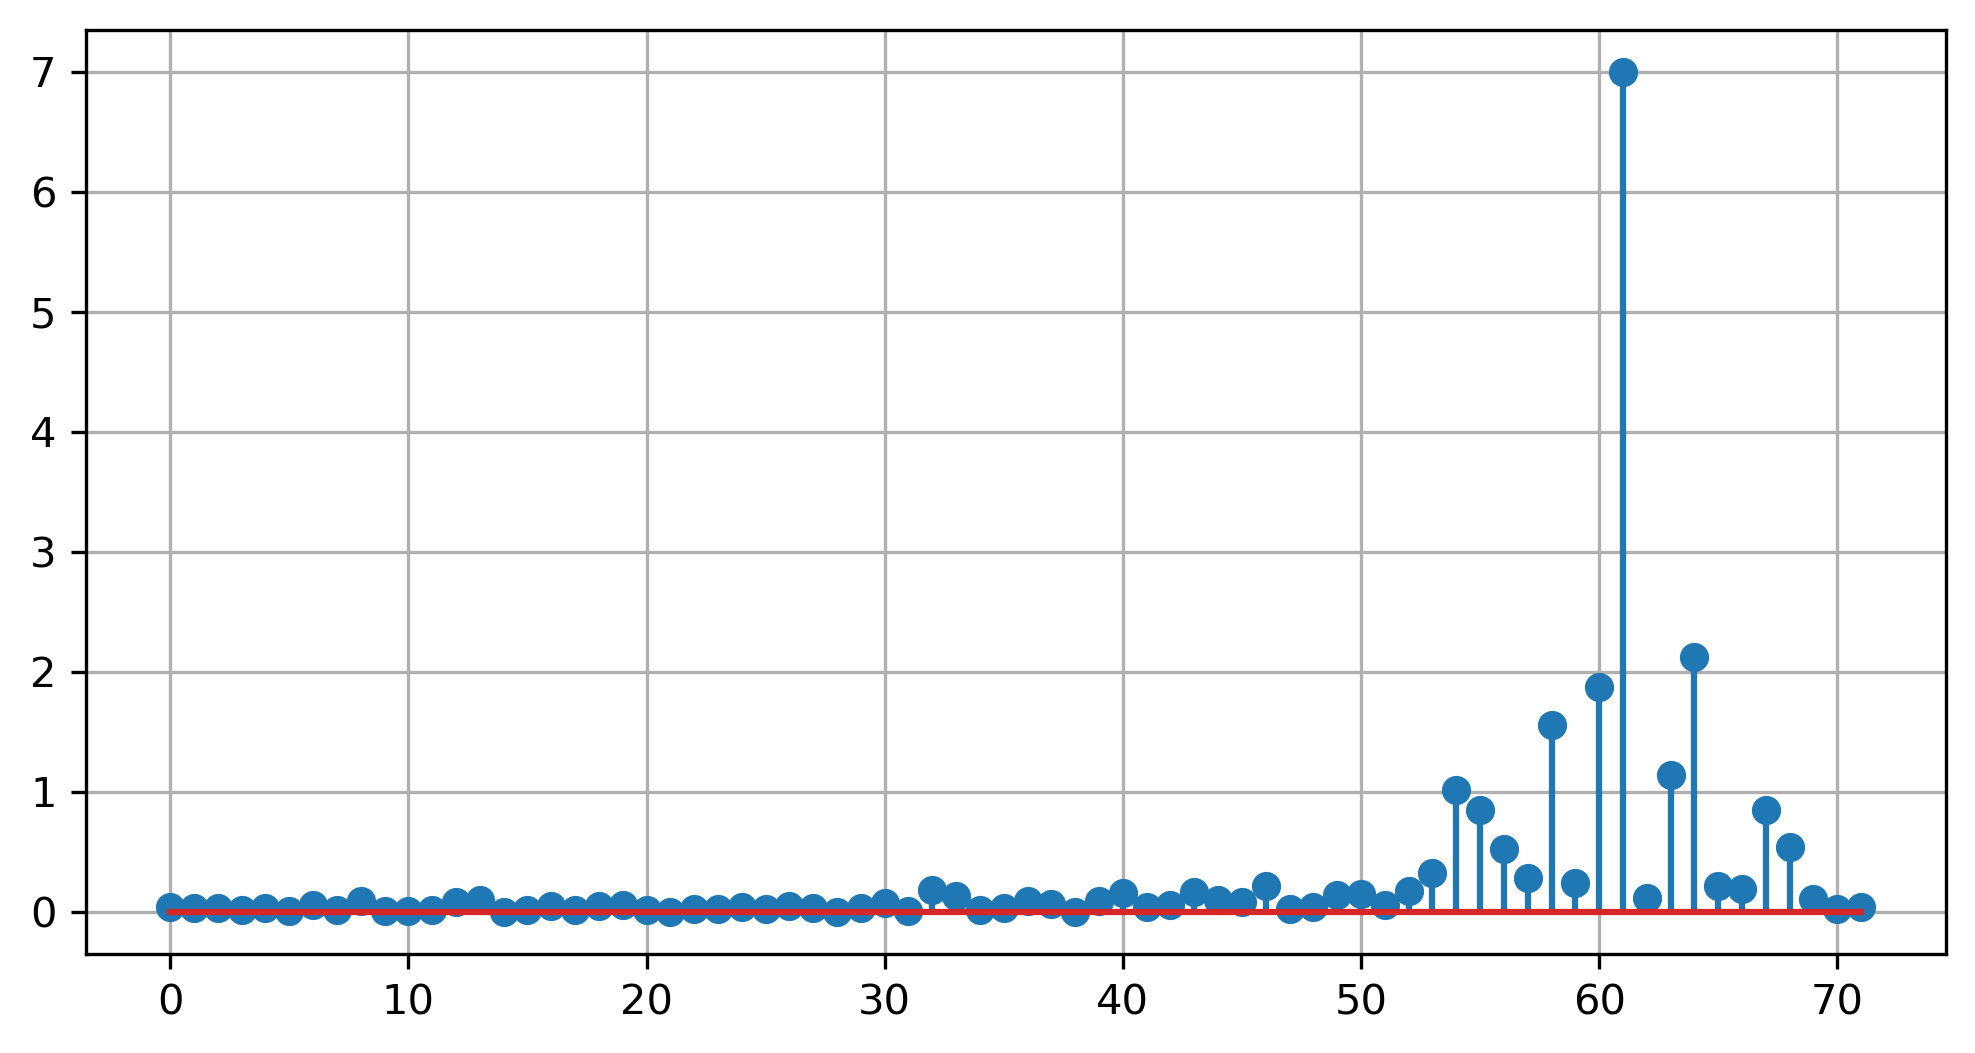

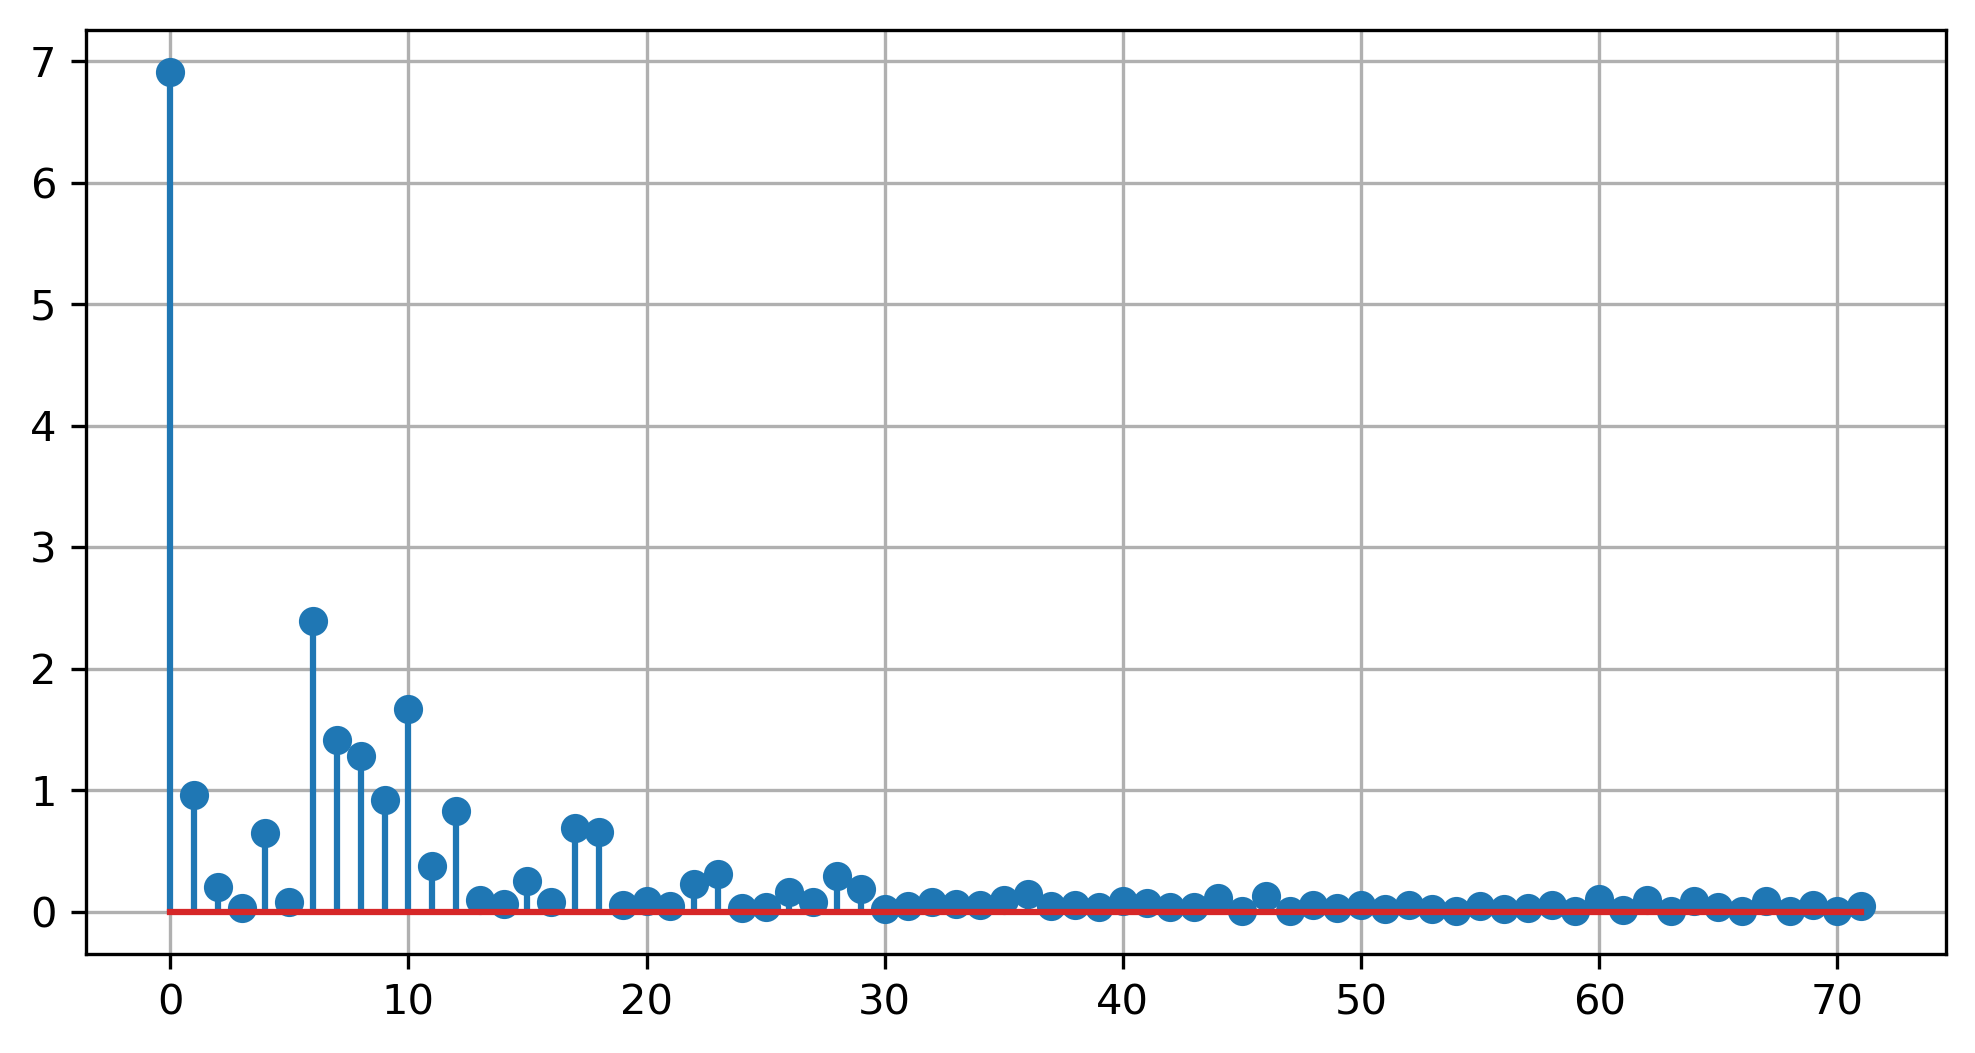

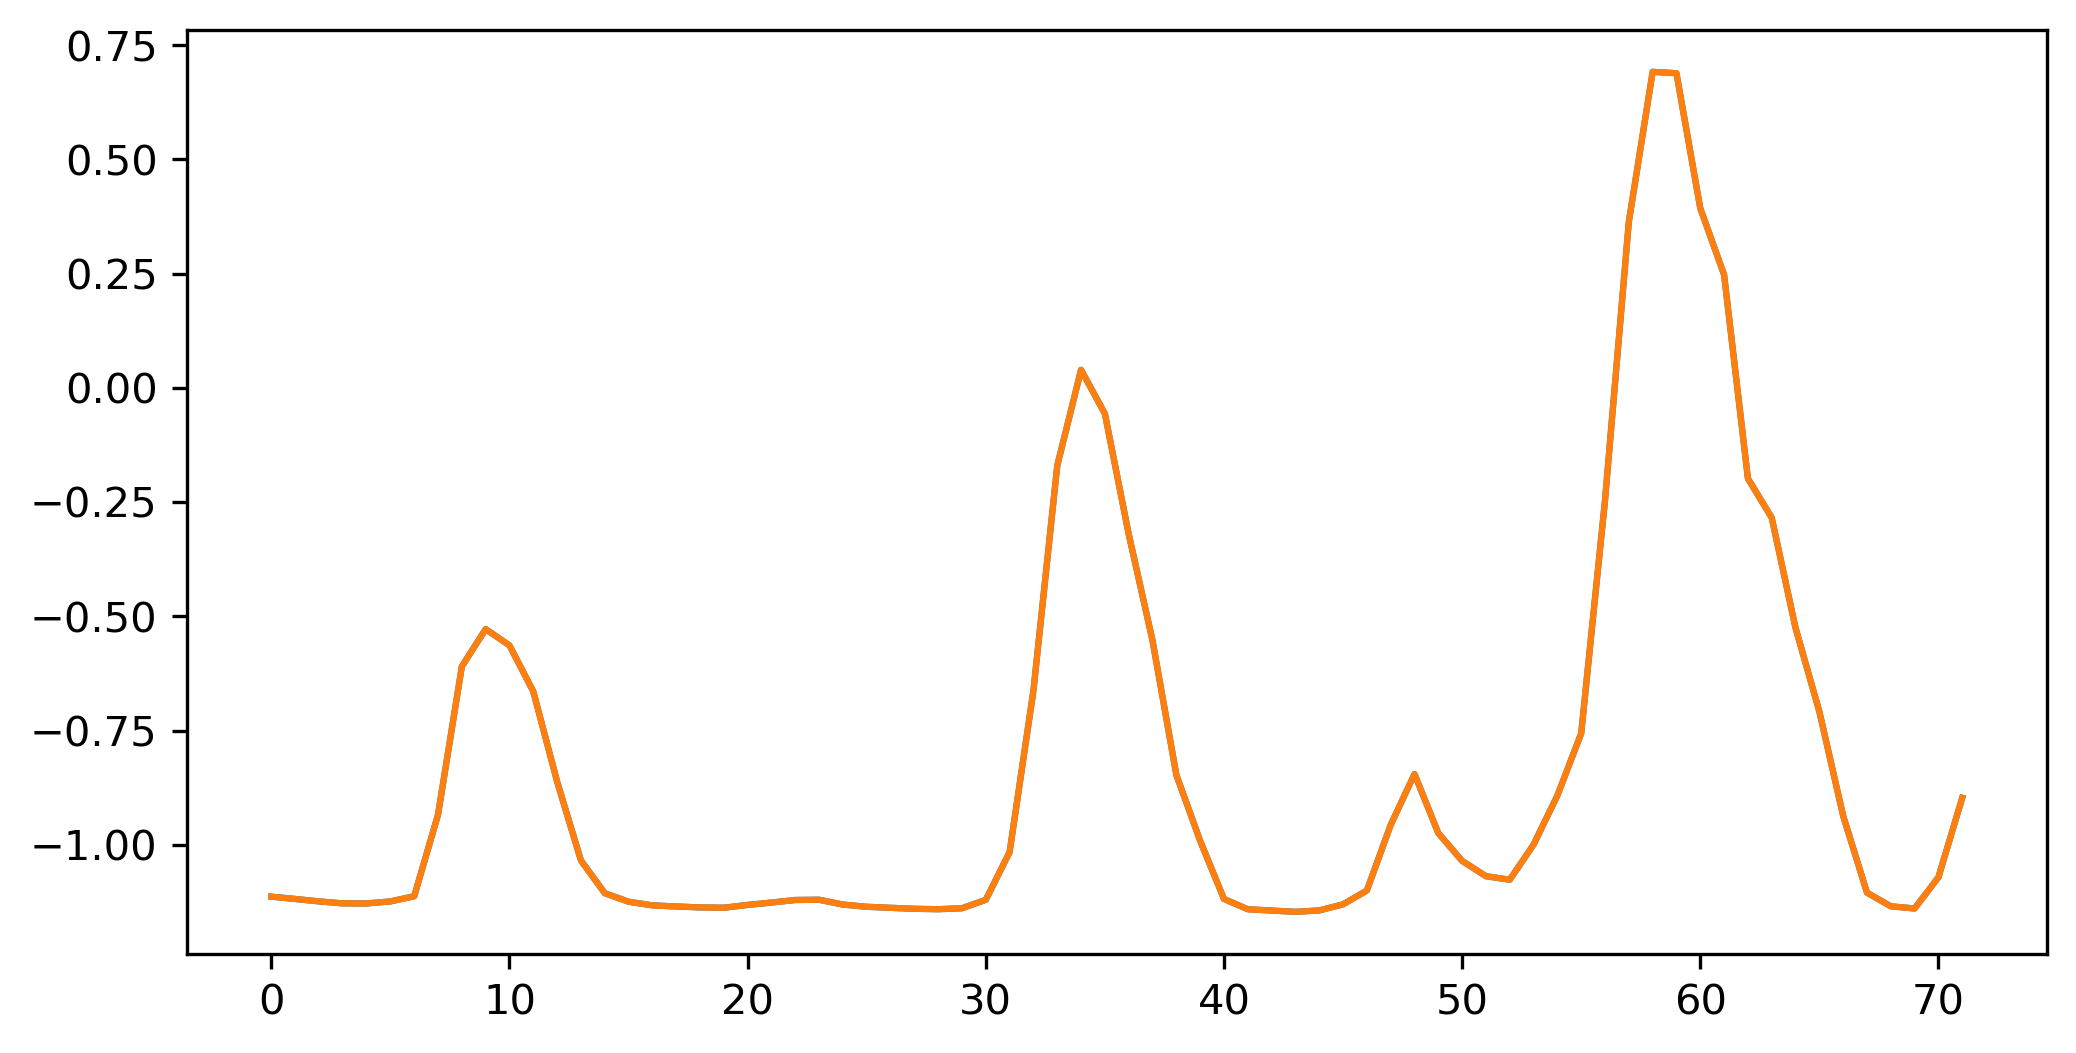

In [89]:
from scipy.linalg import svd,orth

# read in DSM2 training data
DATASET_FILE_PATH = 'generated_datasets/DSM2/datasets.h5'
with h5py.File(DATASET_FILE_PATH, "r") as hf1:
    h5_X = hf1["train"]["X"][:]

# select one of the snapshots
Y = h5_X[0]

# calculate U for each snapshot and then average them
num_snaps = h5_X.shape[0]
num_meas = h5_X.shape[1]
A = np.zeros((num_meas,num_meas))
for i in range(num_snaps):
    U ,s, Vh = svd(h5_X[i])
    A += U
#A = A / num_snaps
A = orth(A)
A = np.transpose(A)

# plt.figure()
# plt.plot(X0[:,0])

plt.figure()
plt.plot(A[:,0])

# use U as the basis
X = np.matmul(A,Y[:,0])

plt.figure()
plt.stem(np.abs(X))
plt.grid(True)

# IDCT matrix
P = idct(identity(72).toarray(), axis=0, norm='ortho')
Xd = np.matmul(P,Y[:,0])

plt.figure()
plt.stem(np.abs(Xd))
plt.grid(True)

Yr = np.matmul(np.transpose(A),X)

plt.figure()
plt.plot(Y[:,0])
plt.plot(Yr)
